Preprocessed data:
            Month                                              Cost    Year  \
Date                                                                          
2024-01-31      5       £3,133.00£4,550.00£6,950.00£18,400.00£270.00  10120   
2024-02-29     20  £3,133.00£165.00£600.00£11,709.50£1,777.10£400...  20240   
2024-03-31     18  £2,548.00£3,613.50£1,000.00£18,750.00£3,744.00...  12144   
2024-04-30     16                 £2,160.00£3,200.00£9,775.00£720.00   8096   
2024-05-31     20               £3,523.50£5,821.50£1,200.00£4,550.00   8096   

               Cost  
Date                 
2024-01-31  33303.0  
2024-02-29  18977.1  
2024-03-31  34721.0  
2024-04-30  15855.0  
2024-05-31  15095.0  


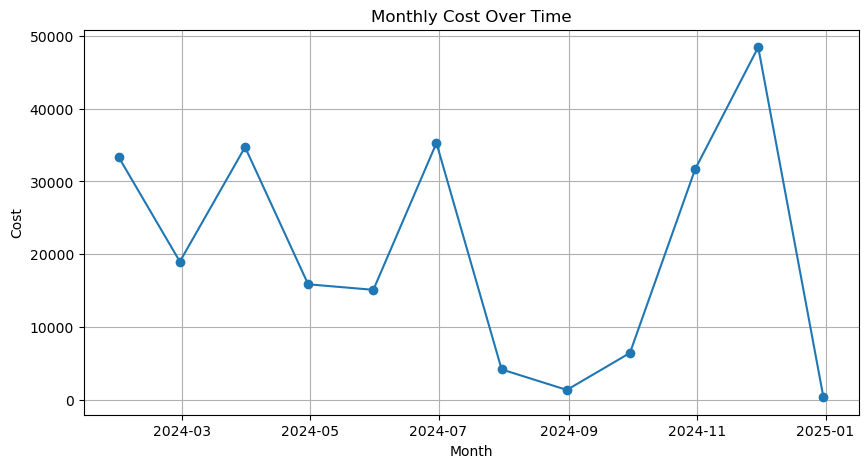

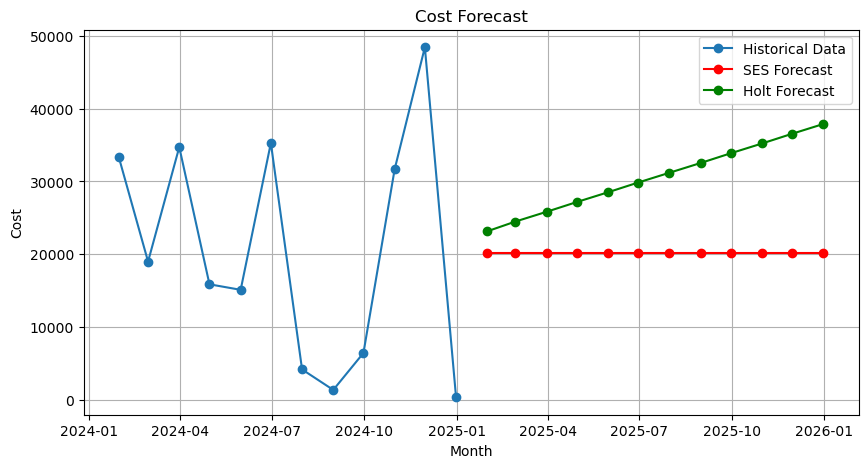

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from pandas.tseries.offsets import DateOffset
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Step 1: Load the data
file_path = 'Uni venue examples.csv'
df = pd.read_csv(file_path)

# Step 2: Preprocess the data
# Create a mapping from month names to month numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Map the month names to numbers
df['Month'] = df['Month'].map(month_map)

# Drop rows where the mapping failed
df.dropna(subset=['Month'], inplace=True)

# Assume the data is for a single year (e.g., 2024)
df['Year'] = 2024

# Combine year and month into a date column
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Ensure the 'Cost' column is numeric, removing '£' and ',' symbols
df['Cost'] = df[' Cost '].str.replace('£', '').str.replace(',', '').astype(float)

# Drop any rows with missing values in 'Cost'
df.dropna(subset=['Cost'], inplace=True)

# Resample to monthly data (sum if there are multiple entries per month)
df = df.resample('M').sum()

# Check if the data preprocessing is correct
print("Preprocessed data:")
print(df.head())

# Step 3: Visualize the data
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Cost'], marker='o')
plt.title('Monthly Cost Over Time')
plt.xlabel('Month')
plt.ylabel('Cost')
plt.grid(True)
plt.show()

# Step 4: Model the data using Simple Exponential Smoothing
try:
    ses_model = SimpleExpSmoothing(df['Cost']).fit(optimized=True)
    ses_forecast = ses_model.forecast(steps=12)
except Exception as e:
    print("Error with Simple Exponential Smoothing:", e)
    ses_forecast = None

# Model the data using Holt's Linear Trend Model
try:
    holt_model = Holt(df['Cost']).fit(optimized=True)
    holt_forecast = holt_model.forecast(steps=12)
except Exception as e:
    print("Error with Holt's Linear Trend Model:", e)
    holt_forecast = None

# Create future dates for plotting
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(1, 13)]

# Convert forecasts to DataFrames
if ses_forecast is not None:
    ses_forecast_df = pd.DataFrame(ses_forecast, index=future_dates, columns=['SES Forecast'])
else:
    ses_forecast_df = pd.DataFrame()

if holt_forecast is not None:
    holt_forecast_df = pd.DataFrame(holt_forecast, index=future_dates, columns=['Holt Forecast'])
else:
    holt_forecast_df = pd.DataFrame()

# Step 5: Visualize the forecast
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Cost'], label='Historical Data', marker='o')

if not ses_forecast_df.empty:
    plt.plot(ses_forecast_df.index, ses_forecast_df['SES Forecast'], label='SES Forecast', marker='o', color='red')

if not holt_forecast_df.empty:
    plt.plot(holt_forecast_df.index, holt_forecast_df['Holt Forecast'], label='Holt Forecast', marker='o', color='green')

plt.title('Cost Forecast')
plt.xlabel('Month')
plt.ylabel('Cost')
plt.legend()
plt.grid(True)
plt.show()
